In [1]:
# Dependencies
import matplotlib.pyplot as plt
import requests
import pandas as pd
from scipy.stats import linregress
from config import tmdb_api_key
from config import omdb_api_key
import json
import numpy as np
import cpi
import time

In [2]:
# Check that the CSV was read properly
movie_import = pd.read_csv("movies_metadata.csv", low_memory=False)
print(movie_import.shape)
movie_import.head()

(45466, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
movie_import.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [4]:
# Check the dataset's budget and revenue values to see how many entries don't have said data
print("Budget value counts:")
print(movie_import["budget"].value_counts())
print("---------------------------------------")
print("Revenue value counts:")
print(movie_import["revenue"].value_counts())

Budget value counts:
budget
0           36573
5000000       286
10000000      259
20000000      243
2000000       242
            ...  
923             1
72500000        1
2160000         1
4439832         1
1254040         1
Name: count, Length: 1226, dtype: int64
---------------------------------------
Revenue value counts:
revenue
0.0           38052
12000000.0       20
11000000.0       19
10000000.0       19
2000000.0        18
              ...  
36565280.0        1
439564.0          1
35610100.0        1
10217873.0        1
1413000.0         1
Name: count, Length: 6863, dtype: int64


In [5]:
# Drop duplicate movies (movie entries with the same title and release date) from the imported data
movie_import.drop_duplicates(subset=["release_date", "title"], keep='first', inplace=True)

In [6]:
# View if a movie had 0 budget or not (true/false)
# First, convert the budget column from a string to numeric and write NaN values to non-numeric cells
movie_import["budget"] = pd.to_numeric(movie_import['budget'], errors='coerce', downcast='integer')
no_budget = movie_import["budget"]==0
no_budget

0        False
1        False
2         True
3        False
4         True
         ...  
45461     True
45462     True
45463     True
45464     True
45465     True
Name: budget, Length: 45434, dtype: bool

In [7]:
# Create a DataFrame from the last cell's result
no_budget_df = movie_import[no_budget]
# Remove the rows with zero budget movies
movie_import=movie_import[~no_budget]
movie_import

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
5,False,NaN,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
6,False,NaN,58000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,1995-12-15,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45402,False,NaN,2000000.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,293654,tt3761706,ru,Корпоратив,"Igor, a furniture store manager, tries to figu...",...,2014-09-18,0.0,89.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Corporate Event,False,3.5,4.0
45408,False,NaN,2000000.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,100152,tt0417949,ru,Марс,"Somewhere deep, deep in Russia there is a town...",...,2004-11-11,0.0,100.0,[],Released,NaN,Mars,False,5.0,2.0
45409,False,NaN,800000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,2006-11-23,1328612.0,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0
45412,False,NaN,2000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,2010-09-30,1268793.0,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Pro Lyuboff,False,4.0,3.0


In [8]:
# View if a movie had 0 budget or not (true/false)
# First, convert the budget column from a string to numeric and write NaN values to non-numeric cells
movie_import["revenue"] = pd.to_numeric(movie_import["revenue"], errors="coerce", downcast="float")
no_revenue = movie_import["revenue"]==0
no_revenue

0        False
1        False
3        False
5        False
6         True
         ...  
45402     True
45408     True
45409    False
45412    False
45422    False
Name: revenue, Length: 8883, dtype: bool

In [9]:
# Create a DataFrame from the last block's result
no_revenue_df = movie_import[no_revenue]
# Remove the rows with zero budget movies
movie_import=movie_import[~no_revenue]
print(movie_import.shape)
movie_import

(5378, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
5,False,NaN,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
8,False,NaN,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45250,False,NaN,12000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,24049,tt0479751,ta,சிவாஜி,Corrupt police and politicians target a comput...,...,2007-06-14,19000000.0,185.0,"[{'iso_639_1': 'ta', 'name': 'தமிழ்'}, {'iso_6...",Released,NaN,Sivaji: The Boss,False,6.9,25.0
45399,False,NaN,750000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",NaN,280422,tt3805180,ru,Все и сразу,NaN,...,2014-06-05,3.0,0.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,All at Once,False,6.0,4.0
45409,False,NaN,800000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,2006-11-23,1328612.0,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0
45412,False,NaN,2000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,2010-09-30,1268793.0,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Pro Lyuboff,False,4.0,3.0


In [10]:
# Check if there are any 0 values remaining for either budget or revenue
print(f"Budget check: ")
print(movie_import["budget"].min())
print(f"Revenue check: ")
print(movie_import["revenue"].min())

Budget check: 
1.0
Revenue check: 
1.0


In [11]:
# Further fitler down the original movie dataset by removing movies with budgets and revenues less than $1000
movie_prep1 = movie_import[movie_import["budget"]>=1000]
movie_prep1 = movie_import[movie_import["revenue"]>=1000]
movie_prep1

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
5,False,NaN,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
8,False,NaN,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45167,False,NaN,11000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,395834,tt5362988,en,Wind River,An FBI agent teams with the town's veteran gam...,...,2017-08-03,184770205.0,111.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Nothing is harder to track than the truth.,Wind River,False,7.4,181.0
45250,False,NaN,12000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,24049,tt0479751,ta,சிவாஜி,Corrupt police and politicians target a comput...,...,2007-06-14,19000000.0,185.0,"[{'iso_639_1': 'ta', 'name': 'தமிழ்'}, {'iso_6...",Released,NaN,Sivaji: The Boss,False,6.9,25.0
45409,False,NaN,800000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,2006-11-23,1328612.0,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0
45412,False,NaN,2000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,2010-09-30,1268793.0,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Pro Lyuboff,False,4.0,3.0


In [12]:
# Make a new DataFrame and import the title column from the metadata and make a blank id column to be populate
movie_prep2 = pd.DataFrame(movie_prep1["original_title"])
movie_prep2.rename(columns={"original_title": "Title"}, inplace=True)
movie_prep2['id'] = ''
movie_prep2

,Title,id
0,Toy Story,
1,Jumanji,
3,Waiting to Exhale,
5,Heat,
8,Sudden Death,
...,...,...
45167,Wind River,
45250,சிவாஜி,
45409,Dikari,
45412,Про любоff,


In [13]:
movie_list = movie_prep2.sample(1000)
movie_list.reset_index(inplace=True, drop=True)
movie_list

,Title,id
0,Skyfall,
1,Carnosaur,
2,F.C. De Kampioenen: Kampioen zijn blijft plezant,
3,Suffragette,
4,10 Things I Hate About You,
...,...,...
995,Despicable Me 2,
996,Son of God,
997,The Hand,
998,The Good Dinosaur,


In [14]:
# Test a TMDB API call based on an index of the movie list and printing the json response
movie=movie_list['Title'][100]
base_url="https://api.themoviedb.org/3/search/movie?"
build_url = f'https://api.themoviedb.org/3/search/movie?query={movie}&api_key={tmdb_api_key}'
response=requests.get(build_url).json()
#print(response.url)
print(json.dumps(response, indent=4, sort_keys=True))

{
    "page": 1,
    "results": [
        {
            "adult": false,
            "backdrop_path": "/hPHahVM3JDlE0Zexu6avavypk0g.jpg",
            "genre_ids": [
                28,
                12,
                878,
                10770
            ],
            "id": 13001,
            "original_language": "en",
            "original_title": "Stargate: The Ark of Truth",
            "overview": "SG-1 searches for an ancient weapon which could help them defeat the Ori, and discover it may be in the Ori's own home galaxy. As the Ori prepare to send ships through to the Milky Way to attack Earth, SG-1 travels to the Ori galaxy aboard the Odyssey. The International Oversight committee have their own plans and SG-1 finds themselves in a distant galaxy fighting two powerful enemies.",
            "popularity": 15.145,
            "poster_path": "/kIqsCdZBmKYuPwaDnrFYzK1gqlM.jpg",
            "release_date": "2008-03-11",
            "title": "Stargate: The Ark of Truth",
        

In [15]:
# Test an OMDB API call based on an index of the movie list and printing the json response
url = "http://www.omdbapi.com/?t="
api_key_url = "&apikey=" + omdb_api_key
movie_name=movie_list["Title"][250]
response = requests.get(url + movie_name + api_key_url).json()
print(json.dumps(response, indent=4, sort_keys=True))

{
    "Actors": "Hulk Hogan, Joan Severance, Kurt Fuller",
    "Awards": "N/A",
    "BoxOffice": "$16,093,651",
    "Country": "United States",
    "DVD": "30 Nov 2016",
    "Director": "Thomas J. Wright",
    "Genre": "Action, Sport",
    "Language": "English",
    "Metascore": "31",
    "Plot": "A TV-network boss pits a wrestler called Zeus against a wrestler called Rip in a wrestling match.",
    "Poster": "https://m.media-amazon.com/images/M/MV5BNDkxZDkyM2EtNDZhZi00ODg2LThjOWUtNmEzNzY2MDBhNjgwXkEyXkFqcGdeQXVyOTA0NzE2MzA@._V1_SX300.jpg",
    "Production": "N/A",
    "Rated": "PG-13",
    "Ratings": [
        {
            "Source": "Internet Movie Database",
            "Value": "4.4/10"
        },
        {
            "Source": "Rotten Tomatoes",
            "Value": "10%"
        },
        {
            "Source": "Metacritic",
            "Value": "31/100"
        }
    ],
    "Released": "02 Jun 1989",
    "Response": "True",
    "Runtime": "93 min",
    "Title": "No Holds Barr

In [16]:
# Loop through the CSV's Title column to call said movie from the API
# Create an empty list to store unfound movies in the TMDB database into
unfound_movies = []
for index, row in movie_list.iterrows():
    movie=movie_list['Title'][index]
    base_url="https://api.themoviedb.org/3/search/movie?"
    build_url = f'{base_url}query={movie}&api_key={tmdb_api_key}'
    response=requests.get(build_url).json()
    #print(response.url)

    try:
        movie_list.loc[index, "id"] = response['results'][0]['id']
    except (KeyError, IndexError):
        # If no movie name is found, set the movie id as NaN .
        movie_list.loc[index, "id"] = np.nan
        unfound_movies.append(movie_list.loc[index, "Title"])

In [17]:
# View the movies not found in the database
unfound_movies

[]

In [18]:
#Print the DataFrame along with it's shape
print(movie_list.shape)
movie_list

(1000, 2)


,Title,id
0,Skyfall,37724
1,Carnosaur,39283
2,F.C. De Kampioenen: Kampioen zijn blijft plezant,201386
3,Suffragette,245168
4,10 Things I Hate About You,4951
...,...,...
995,Despicable Me 2,93456
996,Son of God,235260
997,The Hand,42149
998,The Good Dinosaur,105864


In [19]:
#Drop NaN rows
movie_list.dropna(how='any',inplace=True)
#Re-check size of Data Frame
movie_list.shape

(1000, 2)

In [20]:
#Add columns name to the DataFrame
movie_list[['imdb_id',
            'budget',
            'genres',
            'revenue',
            'runtime',
            'popularity',
            'release_date',
            'production_countries'
            ,'tmdb_rating']] =''
movie_list

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating
0,Skyfall,37724,,,,,,,,,
1,Carnosaur,39283,,,,,,,,,
2,F.C. De Kampioenen: Kampioen zijn blijft plezant,201386,,,,,,,,,
3,Suffragette,245168,,,,,,,,,
4,10 Things I Hate About You,4951,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
995,Despicable Me 2,93456,,,,,,,,,
996,Son of God,235260,,,,,,,,,
997,The Hand,42149,,,,,,,,,
998,The Good Dinosaur,105864,,,,,,,,,


In [21]:
# Loop through each movie's title for the API call and store the data we want to analyze into our DataFrame

for index, row in movie_list.iterrows():
# Create empty lists to store multiple-value columns' data into 
    genres = []
    production_countries = []
    try:
        movie_id=movie_list['id'][index]
        base_url_ById = "https://api.themoviedb.org/3/movie/"
        build_url_ById=f"{base_url_ById}{movie_id}?api_key={tmdb_api_key}"
        url_byid_response=requests.get(build_url_ById).json()
        movie_list.loc[index, "imdb_id"] = url_byid_response['imdb_id']
        movie_list.loc[index, "release_date"] = url_byid_response['release_date']
        movie_list.loc[index, "revenue"] = url_byid_response['revenue']
        movie_list.loc[index, "runtime"]= url_byid_response['runtime']
        movie_list.loc[index, "Title"]= url_byid_response['title']

        
        
        #extracting genre names from list
        for i in range(0,len(url_byid_response['genres'])):
            current_genre = url_byid_response['genres'][i]['name']
            genres.append(current_genre)
            

        #extracting production_countries names from list
        for i in range(0,len(url_byid_response['production_countries'])):
            current_prod_country = url_byid_response['production_countries'][i]['name']
            production_countries.append(current_prod_country)

        movie_list.loc[index, "popularity"] = url_byid_response['popularity']
        movie_list.loc[index, "budget"] = url_byid_response['budget']
        movie_list.loc[index, "tmdb_rating"] = url_byid_response['vote_average']
        movie_list.loc[index, "genres"] = ", ".join(genres)
        movie_list.loc[index, "production_countries"] = ", ".join(production_countries)
    except (KeyError, IndexError):
        # If no movie name is found, set the movie id as NaN .
        movie_list.loc[index, "imdb_id"] = np.nan
        movie_list.loc[index, "release_date"] = np.nan
        movie_list.loc[index, "revenue"] = np.nan
        movie_list.loc[index, "runtime"]= np.nan
        movie_list.loc[index, "popularity"] = np.nan
        movie_list.loc[index, "budget"] = np.nan
        movie_list.loc[index, "tmdb_rating"] = np.nan
        movie_list.loc[index, "production_countries"] = np.nan
        movie_list.loc[index, "genres"] = np.nan

        

In [22]:
print(movie_list.shape)
# Add a delay (1 second)
# time.sleep(1)  # Sleep for 1 second before next cell
movie_list.head()

(1000, 11)


,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating
0,Skyfall,37724,tt1074638,200000000,"Action, Adventure, Thriller",1142471295,143,46.503,2012-10-24,"United Kingdom, United States of America",7.229
1,Carnosaur,39283,tt0106521,1000000,"Horror, Science Fiction",1753979,83,5.354,1993-05-21,United States of America,4.194
2,F.C. De Kampioenen: Kampioen zijn blijft plezant,201386,tt2671776,3849796,Comedy,7471304,115,2.042,2013-12-17,,5.9
3,Suffragette,245168,tt3077214,14000000,"Drama, History",16002420,106,10.575,2015-10-16,"France, United Kingdom",7.263
4,10 Things I Hate About You,4951,tt0147800,16000000,"Comedy, Romance, Drama",53478166,97,38.211,1999-03-30,United States of America,7.582


In [29]:
# Create a new "Year" column from the "release date" by making a new df converting to datetime

movie_list["release_date"] = pd.to_datetime(movie_list["release_date"])
movie_list["Year"] = movie_list["release_date"].dt.year

for i in range(len(movie_list["Year"])):
    if movie_list.loc[i, "Year"]*0 != 0:
        movie_list.loc[i, "Year"] = np.nan
        print(f"NaN value found at index: {i}")
        print(movie_list.loc[i, "Year"])



# for index, row in movie_list.iterrows():
#     try:
#         movie_list.loc[index, "Year"] = movie_list.loc[index, "release_date"].dt.year
#         movie_list.loc[index, "Year"] = movie_list.loc[index, "Year"].astype(int)
#     except:
#         movie_list.loc[index, "Year"] = movie_list.loc[index, "Year"] = np.nan
movie_list["Year"].dropna()

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating,Year
0,Skyfall,37724,tt1074638,200000000,"Action, Adventure, Thriller",1142471295,143,46.503,2012-10-24,"United Kingdom, United States of America",7.229,2012
1,Carnosaur,39283,tt0106521,1000000,"Horror, Science Fiction",1753979,83,5.354,1993-05-21,United States of America,4.194,1993
2,F.C. De Kampioenen: Kampioen zijn blijft plezant,201386,tt2671776,3849796,Comedy,7471304,115,2.042,2013-12-17,,5.9,2013
3,Suffragette,245168,tt3077214,14000000,"Drama, History",16002420,106,10.575,2015-10-16,"France, United Kingdom",7.263,2015
4,10 Things I Hate About You,4951,tt0147800,16000000,"Comedy, Romance, Drama",53478166,97,38.211,1999-03-30,United States of America,7.582,1999
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Despicable Me 2,93456,tt1690953,76000000,"Animation, Comedy, Family",970761885,98,49.685,2013-06-26,United States of America,6.917,2013
996,Son of God,235260,tt3210686,22000000,Drama,67800064,138,20.846,2014-02-28,United States of America,6.871,2014
997,The Hand,42149,tt0082497,6500000,"Horror, Thriller",566736,104,9.515,1981-04-24,United States of America,5.988,1981
998,The Good Dinosaur,105864,tt1979388,175000000,"Adventure, Animation, Family",332207671,93,51.334,2015-11-14,United States of America,6.7,2015


In [30]:
# Drop the old release date column and reorder the current DataFrame to be nicer
movie_list=movie_list[["Title", "Year", "id", "imdb_id", "genres", "runtime", "budget", "revenue", "production_countries",
           "popularity", "tmdb_rating"]]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating
0,Skyfall,2012,37724,tt1074638,"Action, Adventure, Thriller",143,200000000,1142471295,"United Kingdom, United States of America",46.503,7.229
1,Carnosaur,1993,39283,tt0106521,"Horror, Science Fiction",83,1000000,1753979,United States of America,5.354,4.194
2,F.C. De Kampioenen: Kampioen zijn blijft plezant,2013,201386,tt2671776,Comedy,115,3849796,7471304,,2.042,5.9
3,Suffragette,2015,245168,tt3077214,"Drama, History",106,14000000,16002420,"France, United Kingdom",10.575,7.263
4,10 Things I Hate About You,1999,4951,tt0147800,"Comedy, Romance, Drama",97,16000000,53478166,United States of America,38.211,7.582
...,...,...,...,...,...,...,...,...,...,...,...
995,Despicable Me 2,2013,93456,tt1690953,"Animation, Comedy, Family",98,76000000,970761885,United States of America,49.685,6.917
996,Son of God,2014,235260,tt3210686,Drama,138,22000000,67800064,United States of America,20.846,6.871
997,The Hand,1981,42149,tt0082497,"Horror, Thriller",104,6500000,566736,United States of America,9.515,5.988
998,The Good Dinosaur,2015,105864,tt1979388,"Adventure, Animation, Family",93,175000000,332207671,United States of America,51.334,6.7


In [31]:
# Check the DataFrame's budget and revenue values to see how many entries don't have said data
print("Budget value counts:")
print(movie_list["budget"].value_counts())
print("---------------------------------------")
print("Revenue value counts:")
print(movie_list["revenue"].value_counts())

Budget value counts:
budget
15000000    34
0           30
25000000    30
30000000    28
20000000    28
            ..
19800000     1
21000000     1
5800000      1
4600000      1
49000000     1
Name: count, Length: 245, dtype: int64
---------------------------------------
Revenue value counts:
revenue
0            32
11000000      4
1400000       3
10000000      3
7000000       3
             ..
463406268     1
72661442      1
27900000      1
75700000      1
121616555     1
Name: count, Length: 933, dtype: int64


In [32]:
# View if a movie had 0 budget or not (true/false)
no_budget = movie_list["budget"]==0
# null_imdb_id = movie_list.loc[movie_list]
no_budget

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: budget, Length: 1000, dtype: bool

In [33]:
# Create a DataFrame from the last block's result
no_budget_df = movie_list[no_budget]
# Remove rows with zero budget values
movie_list=movie_list[~no_budget]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating
0,Skyfall,2012,37724,tt1074638,"Action, Adventure, Thriller",143,200000000,1142471295,"United Kingdom, United States of America",46.503,7.229
1,Carnosaur,1993,39283,tt0106521,"Horror, Science Fiction",83,1000000,1753979,United States of America,5.354,4.194
2,F.C. De Kampioenen: Kampioen zijn blijft plezant,2013,201386,tt2671776,Comedy,115,3849796,7471304,,2.042,5.9
3,Suffragette,2015,245168,tt3077214,"Drama, History",106,14000000,16002420,"France, United Kingdom",10.575,7.263
4,10 Things I Hate About You,1999,4951,tt0147800,"Comedy, Romance, Drama",97,16000000,53478166,United States of America,38.211,7.582
...,...,...,...,...,...,...,...,...,...,...,...
995,Despicable Me 2,2013,93456,tt1690953,"Animation, Comedy, Family",98,76000000,970761885,United States of America,49.685,6.917
996,Son of God,2014,235260,tt3210686,Drama,138,22000000,67800064,United States of America,20.846,6.871
997,The Hand,1981,42149,tt0082497,"Horror, Thriller",104,6500000,566736,United States of America,9.515,5.988
998,The Good Dinosaur,2015,105864,tt1979388,"Adventure, Animation, Family",93,175000000,332207671,United States of America,51.334,6.7


In [34]:
# View if a movie had 0 revenue or not (true/false)
no_revenue = movie_list["revenue"]==0
# null_imdb_id = movie_list.loc[movie_list]
no_revenue

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: revenue, Length: 970, dtype: bool

In [35]:
# Removing rows with zero revenue movies
movie_list=movie_list[~no_revenue]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating
0,Skyfall,2012,37724,tt1074638,"Action, Adventure, Thriller",143,200000000,1142471295,"United Kingdom, United States of America",46.503,7.229
1,Carnosaur,1993,39283,tt0106521,"Horror, Science Fiction",83,1000000,1753979,United States of America,5.354,4.194
2,F.C. De Kampioenen: Kampioen zijn blijft plezant,2013,201386,tt2671776,Comedy,115,3849796,7471304,,2.042,5.9
3,Suffragette,2015,245168,tt3077214,"Drama, History",106,14000000,16002420,"France, United Kingdom",10.575,7.263
4,10 Things I Hate About You,1999,4951,tt0147800,"Comedy, Romance, Drama",97,16000000,53478166,United States of America,38.211,7.582
...,...,...,...,...,...,...,...,...,...,...,...
995,Despicable Me 2,2013,93456,tt1690953,"Animation, Comedy, Family",98,76000000,970761885,United States of America,49.685,6.917
996,Son of God,2014,235260,tt3210686,Drama,138,22000000,67800064,United States of America,20.846,6.871
997,The Hand,1981,42149,tt0082497,"Horror, Thriller",104,6500000,566736,United States of America,9.515,5.988
998,The Good Dinosaur,2015,105864,tt1979388,"Adventure, Animation, Family",93,175000000,332207671,United States of America,51.334,6.7


In [36]:
# Check if there are any 0 values remaining for either budget or revenue in the DataFrame
print(f"Budget check: ")
print(movie_list["budget"].min())
print(f"Revenue check: ")
print(movie_list["revenue"].min())

Budget check: 
1
Revenue check: 
2970


In [37]:
# # Dummy test on adjusting for inflation over the years using the cpi library
# budget_past = 438656843
# budget_year = 1991
# budget_2023 = cpi.inflate(budget_past, budget_year)
# round(budget_2023, 2)

In [38]:
# Create new columns in the DataFrame for inflation-adjusted budget and revenue
movie_list['infl_adj_budget'] = ''
movie_list['infl_adj_revenue'] = ''
movie_list

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_94394/455108519.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['infl_adj_budget'] = ''
/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_94394/455108519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['infl_adj_revenue'] = ''


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue
0,Skyfall,2012,37724,tt1074638,"Action, Adventure, Thriller",143,200000000,1142471295,"United Kingdom, United States of America",46.503,7.229,,
1,Carnosaur,1993,39283,tt0106521,"Horror, Science Fiction",83,1000000,1753979,United States of America,5.354,4.194,,
2,F.C. De Kampioenen: Kampioen zijn blijft plezant,2013,201386,tt2671776,Comedy,115,3849796,7471304,,2.042,5.9,,
3,Suffragette,2015,245168,tt3077214,"Drama, History",106,14000000,16002420,"France, United Kingdom",10.575,7.263,,
4,10 Things I Hate About You,1999,4951,tt0147800,"Comedy, Romance, Drama",97,16000000,53478166,United States of America,38.211,7.582,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Despicable Me 2,2013,93456,tt1690953,"Animation, Comedy, Family",98,76000000,970761885,United States of America,49.685,6.917,,
996,Son of God,2014,235260,tt3210686,Drama,138,22000000,67800064,United States of America,20.846,6.871,,
997,The Hand,1981,42149,tt0082497,"Horror, Thriller",104,6500000,566736,United States of America,9.515,5.988,,
998,The Good Dinosaur,2015,105864,tt1979388,"Adventure, Animation, Family",93,175000000,332207671,United States of America,51.334,6.7,,


In [39]:
# POSSIBLE TEMPORARY CODE 
# DROP ANY 2023 DATES TO FIX CPI FUNCTION
print("True = number of films from 2023")
find23 = movie_list["Year"]==2023
find23.value_counts()

True = number of films from 2023


Year
False    958
True       3
Name: count, dtype: int64

In [40]:
# Create a dataframe to hold onto the 2023 films to concatenate after inflation calculation
hold23 = movie_list[find23]
hold23

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue
143,The Super Mario Bros. Movie,2023,502356,tt6718170,"Animation, Family, Adventure, Fantasy, Comedy",93,100000000,1355725263,"Japan, United States of America",486.933,7.766,,
489,Teenage Mutant Ninja Turtles: Mutant Mayhem,2023,614930,tt8589698,"Animation, Comedy, Action",100,75000000,180000000,"Canada, France, United States of America",299.595,7.3,,
911,The Exorcist: Believer,2023,807172,tt12921446,Horror,111,30000000,84561805,United States of America,486.577,5.383,,


In [41]:
hold23['infl_adj_budget'] = hold23['budget'].astype(int)
hold23['infl_adj_revenue'] = hold23['revenue'].astype(float)
hold23

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_94394/3890322621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hold23['infl_adj_budget'] = hold23['budget'].astype(int)
/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_94394/3890322621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hold23['infl_adj_revenue'] = hold23['revenue'].astype(float)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue
143,The Super Mario Bros. Movie,2023,502356,tt6718170,"Animation, Family, Adventure, Fantasy, Comedy",93,100000000,1355725263,"Japan, United States of America",486.933,7.766,100000000,1.355725e+09
489,Teenage Mutant Ninja Turtles: Mutant Mayhem,2023,614930,tt8589698,"Animation, Comedy, Action",100,75000000,180000000,"Canada, France, United States of America",299.595,7.3,75000000,1.800000e+08
911,The Exorcist: Believer,2023,807172,tt12921446,Horror,111,30000000,84561805,United States of America,486.577,5.383,30000000,8.456180e+07


In [42]:
# Drop all rows with the year 2023 from the movie list
movie_list = movie_list[movie_list["Year"]<2023]
print(movie_list.shape)
movie_list.head()

(958, 13)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue
0,Skyfall,2012,37724,tt1074638,"Action, Adventure, Thriller",143,200000000,1142471295,"United Kingdom, United States of America",46.503,7.229,,
1,Carnosaur,1993,39283,tt0106521,"Horror, Science Fiction",83,1000000,1753979,United States of America,5.354,4.194,,
2,F.C. De Kampioenen: Kampioen zijn blijft plezant,2013,201386,tt2671776,Comedy,115,3849796,7471304,,2.042,5.9,,
3,Suffragette,2015,245168,tt3077214,"Drama, History",106,14000000,16002420,"France, United Kingdom",10.575,7.263,,
4,10 Things I Hate About You,1999,4951,tt0147800,"Comedy, Romance, Drama",97,16000000,53478166,United States of America,38.211,7.582,,


In [43]:
# POSSIBLE TEMPORARY CODE 
# NEW CODE FROM CARTER: I THINK WE (AGAIN) NEED TO RESET OUR INDEX AFTER DROPPING OUR NAN ROWS 
# AND MISSING BUDGET/REVENUE ROWS
# movie_list.reset_index(inplace=True, drop=True)

In [44]:
# # Defining a function to calculate a running inflation adjusted value for a column in a dataframe
def inflate_column(data, column):
    #     Adjust for inflation the series of values in column of the dataframe data
    return data.apply(lambda x: cpi.inflate(x[column], x.Year), axis=1)

# adjust the production budget 
movie_list.loc[:,'budget'] = movie_list['budget'].astype(int)
movie_list.loc[:,'infl_adj_budget'] = inflate_column(movie_list, 'budget')
#adjust the worldwide gross profits
movie_list.loc[:,'infl_adj_revenue'] = inflate_column(movie_list, 'revenue').astype(float)

# calculate the real worldwide net profit
movie_list.loc[:,'real_profit'] = movie_list.apply(lambda x: x.infl_adj_revenue - x.infl_adj_budget, axis=1)
movie_list

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_94394/4141791079.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list.loc[:,'real_profit'] = movie_list.apply(lambda x: x.infl_adj_revenue - x.infl_adj_budget, axis=1)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit
0,Skyfall,2012,37724,tt1074638,"Action, Adventure, Thriller",143,200000000,1142471295,"United Kingdom, United States of America",46.503,7.229,254932620.190423,1456266003.633479,1.201333e+09
1,Carnosaur,1993,39283,tt0106521,"Horror, Science Fiction",83,1000000,1753979,United States of America,5.354,4.194,2025294.117647,3552323.351176,1.527029e+06
2,F.C. De Kampioenen: Kampioen zijn blijft plezant,2013,201386,tt2671776,Comedy,115,3849796,7471304,,2.042,5.9,4836351.980752,9385914.448246,4.549562e+06
3,Suffragette,2015,245168,tt3077214,"Drama, History",106,14000000,16002420,"France, United Kingdom",10.575,7.263,17286397.178261,19758870.566668,2.472473e+06
4,10 Things I Hate About You,1999,4951,tt0147800,"Comedy, Romance, Drama",97,16000000,53478166,United States of America,38.211,7.582,28106122.44898,93941492.621429,6.583537e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Despicable Me 2,2013,93456,tt1690953,"Animation, Comedy, Family",98,76000000,970761885,United States of America,49.685,6.917,95475903.278287,1219531155.769842,1.124055e+09
996,Son of God,2014,235260,tt3210686,Drama,138,22000000,67800064,United States of America,20.846,6.871,27196581.846445,83814999.535009,5.661842e+07
997,The Hand,1981,42149,tt0082497,"Horror, Thriller",104,6500000,566736,United States of America,9.515,5.988,20926925.192519,1824621.827063,-1.910230e+07
998,The Good Dinosaur,2015,105864,tt1979388,"Adventure, Animation, Family",93,175000000,332207671,United States of America,51.334,6.7,216079964.728268,410190981.897944,1.941110e+08


In [45]:
# Concatenate DataFrames horizontally (side by side)
movie_list = pd.concat([movie_list, hold23], axis=0)

In [46]:
# Looking at a sampling of the dataframe
print(movie_list.shape)
movie_list.sample(5)

(961, 14)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit
408,47 Ronin,2013,64686,tt1335975,"Drama, Action, Fantasy",119,175000000,151783839,"Hungary, Japan, United Kingdom, United States ...",25.109,6.2,219845829.917109,190680251.731199,-2.916558e+07
955,Casualties of War,1989,10142,tt0097027,"Drama, History, War",113,22500000,18671317,United States of America,15.835,7.15,53102721.774194,44066566.747056,-9.036155e+06
337,Pretty Woman,1990,114,tt0100405,"Comedy, Romance",119,14000000,463406268,United States of America,43.326,7.451,31347895.944912,1037629390.677429,1.006281e+09
874,Star Wars: The Clone Wars,2008,12180,tt1185834,"Animation, Action, Science Fiction, Adventure",98,8500000,68282844,United States of America,18.757,6.115,11553798.600112,92814850.284576,8.126105e+07
652,Paranoia,2013,115348,tt1413495,"Drama, Thriller",106,35000000,17056265,"India, United States of America",13.45,5.717,43969165.983422,21427135.624064,-2.254203e+07


In [47]:
for index, row in movie_list.iterrows():
    try:
        imdb_id=movie_list["imdb_id"][index]
        base_url_ById = "http://www.omdbapi.com/?i="
        build_url_ById=f"{base_url_ById}{imdb_id}&apikey={omdb_api_key}"
        url_byid_response=requests.get(build_url_ById).json()
        rating_url = url_byid_response['imdbRating']
        movie_list.loc[index, "imdb_rating"] = rating_url
        votes_url = url_byid_response['imdbVotes']
        movie_list.loc[index, "imdb_votes"] = votes_url
    except:
        movie_list.loc[index, "imdb_rating"] = np.nan
        movie_list.loc[index, "imdb_votes"] = np.nan
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes
0,Skyfall,2012,37724,tt1074638,"Action, Adventure, Thriller",143,200000000,1142471295,"United Kingdom, United States of America",46.503,7.229,254932620.190423,1456266003.633479,1.201333e+09,7.8,"718,573"
1,Carnosaur,1993,39283,tt0106521,"Horror, Science Fiction",83,1000000,1753979,United States of America,5.354,4.194,2025294.117647,3552323.351176,1.527029e+06,3.6,"4,264"
2,F.C. De Kampioenen: Kampioen zijn blijft plezant,2013,201386,tt2671776,Comedy,115,3849796,7471304,,2.042,5.9,4836351.980752,9385914.448246,4.549562e+06,5.2,"1,010"
3,Suffragette,2015,245168,tt3077214,"Drama, History",106,14000000,16002420,"France, United Kingdom",10.575,7.263,17286397.178261,19758870.566668,2.472473e+06,6.9,"43,828"
4,10 Things I Hate About You,1999,4951,tt0147800,"Comedy, Romance, Drama",97,16000000,53478166,United States of America,38.211,7.582,28106122.44898,93941492.621429,6.583537e+07,7.3,"368,004"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,The Good Dinosaur,2015,105864,tt1979388,"Adventure, Animation, Family",93,175000000,332207671,United States of America,51.334,6.7,216079964.728268,410190981.897944,1.941110e+08,6.7,"123,582"
999,Pride & Prejudice,2005,4348,tt0414387,"Drama, Romance",127,28000000,121616555,"France, United Kingdom, United States of America",57.84,8.084,41957706.09319,182241131.098438,1.402834e+08,7.8,"317,633"
143,The Super Mario Bros. Movie,2023,502356,tt6718170,"Animation, Family, Adventure, Fantasy, Comedy",93,100000000,1355725263,"Japan, United States of America",486.933,7.766,100000000,1355725263.0,NaN,7.1,"197,202"
489,Teenage Mutant Ninja Turtles: Mutant Mayhem,2023,614930,tt8589698,"Animation, Comedy, Action",100,75000000,180000000,"Canada, France, United States of America",299.595,7.3,75000000,180000000.0,NaN,7.3,"42,049"


# Movie Data Analysis

In [48]:
# Define custom bin edges
bin_edges = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
labels =["1920s", "1930s", "1940s", "1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010s", "2020s"]

# Cut the data into custom intervals
movie_list.loc[:,'Decades'] = pd.cut(movie_list['Year'], bins=bin_edges,labels=labels)
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes,Decades
0,Skyfall,2012,37724,tt1074638,"Action, Adventure, Thriller",143,200000000,1142471295,"United Kingdom, United States of America",46.503,7.229,254932620.190423,1456266003.633479,1.201333e+09,7.8,"718,573",2010s
1,Carnosaur,1993,39283,tt0106521,"Horror, Science Fiction",83,1000000,1753979,United States of America,5.354,4.194,2025294.117647,3552323.351176,1.527029e+06,3.6,"4,264",1990s
2,F.C. De Kampioenen: Kampioen zijn blijft plezant,2013,201386,tt2671776,Comedy,115,3849796,7471304,,2.042,5.9,4836351.980752,9385914.448246,4.549562e+06,5.2,"1,010",2010s
3,Suffragette,2015,245168,tt3077214,"Drama, History",106,14000000,16002420,"France, United Kingdom",10.575,7.263,17286397.178261,19758870.566668,2.472473e+06,6.9,"43,828",2010s
4,10 Things I Hate About You,1999,4951,tt0147800,"Comedy, Romance, Drama",97,16000000,53478166,United States of America,38.211,7.582,28106122.44898,93941492.621429,6.583537e+07,7.3,"368,004",1990s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,The Good Dinosaur,2015,105864,tt1979388,"Adventure, Animation, Family",93,175000000,332207671,United States of America,51.334,6.7,216079964.728268,410190981.897944,1.941110e+08,6.7,"123,582",2010s
999,Pride & Prejudice,2005,4348,tt0414387,"Drama, Romance",127,28000000,121616555,"France, United Kingdom, United States of America",57.84,8.084,41957706.09319,182241131.098438,1.402834e+08,7.8,"317,633",2000s
143,The Super Mario Bros. Movie,2023,502356,tt6718170,"Animation, Family, Adventure, Fantasy, Comedy",93,100000000,1355725263,"Japan, United States of America",486.933,7.766,100000000,1355725263.0,NaN,7.1,"197,202",2020s
489,Teenage Mutant Ninja Turtles: Mutant Mayhem,2023,614930,tt8589698,"Animation, Comedy, Action",100,75000000,180000000,"Canada, France, United States of America",299.595,7.3,75000000,180000000.0,NaN,7.3,"42,049",2020s


In [49]:
# Sorting movie_list df revenue column ascending=False
sorted_revenue_desc = movie_list.sort_values(by='infl_adj_revenue', ascending=False)
top_ten_df = sorted_revenue_desc.iloc[0:10, :] 
top_ten_df

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes,Decades
130,Titanic,1997,597,tt0120338,"Drama, Romance",194,200000000,2264162353,United States of America,139.952,7.899,364679127.725857,4128463759.608816,3.763785e+09,7.9,"1,248,724",1990s
906,The Avengers,2012,24428,tt0848228,"Science Fiction, Action, Adventure",143,220000000,1518815515,United States of America,91.861,7.71,280425882.209465,1935978094.124084,1.655552e+09,8.0,"1,434,660",2010s
177,The Empire Strikes Back,1980,1891,tt0080684,"Adventure, Action, Science Fiction",124,18000000,538400000,United States of America,26.25,8.392,63929490.291262,1912202087.378641,1.848273e+09,8.7,"1,344,359",1970s
528,Frozen,2013,109445,tt2294629,"Animation, Family, Adventure, Fantasy",102,150000000,1274219009,United States of America,85.367,7.246,188439282.786094,1600752774.455779,1.412313e+09,7.4,"648,268",2010s
974,The Lion King,1994,8587,tt0110357,"Family, Animation, Drama",89,45000000,763455561,United States of America,106.55,8.255,88862854.251012,1507618672.094838,1.418756e+09,8.5,"1,106,816",1990s
163,Finding Nemo,2003,12,tt0266543,"Animation, Family",100,94000000,940335536,United States of America,80.914,7.824,149508532.608696,1495619001.565652,1.346110e+09,8.2,"1,085,322",2000s
0,Skyfall,2012,37724,tt1074638,"Action, Adventure, Thriller",143,200000000,1142471295,"United Kingdom, United States of America",46.503,7.229,254932620.190423,1456266003.633479,1.201333e+09,7.8,"718,573",2010s
273,Shrek 2,2004,809,tt0298148,"Animation, Family, Comedy, Fantasy, Adventure",93,150000000,928760770,United States of America,91.766,7.25,232388830.068819,1438890858.360773,1.206502e+09,7.3,"490,265",2000s
143,The Super Mario Bros. Movie,2023,502356,tt6718170,"Animation, Family, Adventure, Fantasy, Comedy",93,100000000,1355725263,"Japan, United States of America",486.933,7.766,100000000,1355725263.0,NaN,7.1,"197,202",2020s
451,Superman,1978,1924,tt0078346,"Science Fiction, Action, Adventure",143,55000000,300218018,"Panama, Switzerland, United Kingdom, United St...",45.425,7.118,246871549.079755,1347550675.732975,1.100679e+09,7.4,"183,558",1970s


<Axes: title={'center': 'Top 10 Grossing Movies (1922-2022)'}, xlabel='Movie Titles', ylabel='Movie Revenue'>

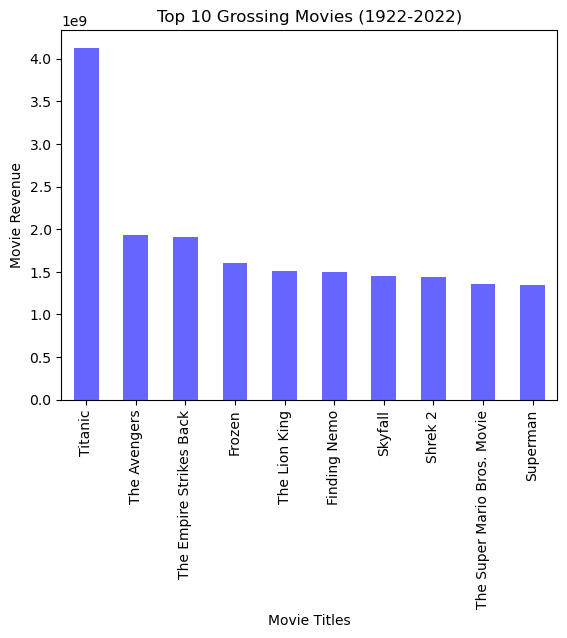

In [50]:
# Create a bar chart to display top 10 grossing movies

top_ten_df.plot("Title", "infl_adj_revenue", kind='bar', alpha=0.6, color='blue', title="Top 10 Grossing Movies (1922-2022)",
                xlabel="Movie Titles", ylabel="Movie Revenue", legend='')


# ax=top_ten_df.plot("Title", "revenue", kind='bar', alpha=0.6, color='blue', title="Top 10 Grossing Movies (1922-2022)",
#                 xlabel="Movie Titles", ylabel="Movie Revenue", legend='')
# ax.set_xticklabels(top_ten_df['Title'], rotation=45)
# plt.show()

In [51]:
country_df = movie_list.copy(deep=True)
country_df[['country1', 'country2', 'country3', 'country4', 'country5', 'country6']] = country_df['production_countries'].str.split(', ', expand=True, n=5)
country_df.sample(10)

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,...,real_profit,imdb_rating,imdb_votes,Decades,country1,country2,country3,country4,country5,country6
136,Mongol: The Rise of Genghis Khan,2007,12246,tt0416044,"History, Adventure, War, Action",125,18000000,26527510,"Germany, Kazakhstan, Russia",10.056,...,1.203624e+07,7.2,"48,364",2000s,Germany,Kazakhstan,Russia,None,None,None
194,Attack of the 50 Foot Woman,1958,18724,tt0051380,"Horror, Science Fiction, Drama",66,88000,480000,United States of America,9.794,...,3.969576e+06,5.0,"6,012",1950s,United States of America,None,None,None,None,None
612,The Vatican Tapes,2015,157544,tt1524575,"Thriller, Horror",91,13000000,1784763,United States of America,32.598,...,-1.384793e+07,4.7,"18,864",2010s,United States of America,None,None,None,None,None
923,Hard Contract,1969,67220,tt0064406,"Crime, Romance",106,4000000,1750000,United States of America,2.285,...,-1.794206e+07,5.7,607,1960s,United States of America,None,None,None,None,None
394,Horton Hears a Who!,2008,12222,tt0451079,"Animation, Comedy, Family, Adventure, Fantasy",86,85000000,298572799,United States of America,26.108,...,2.903032e+08,6.8,"147,563",2000s,United States of America,None,None,None,None,None
503,The Final Destination,2009,19912,tt1144884,"Horror, Mystery",82,40000000,186167139,United States of America,42.38,...,1.993901e+08,5.1,"112,308",2000s,United States of America,None,None,None,None,None
296,All About the Benjamins,2002,13950,tt0278295,"Action, Adventure, Comedy",95,14000000,25482931,United States of America,10.932,...,1.868003e+07,5.8,"15,343",2000s,United States of America,None,None,None,None,None
515,Friday the 13th Part VII: The New Blood,1988,10281,tt0095179,Horror,88,2800000,19170001,United States of America,28.479,...,4.049673e+07,5.2,"40,520",1980s,United States of America,None,None,None,None,None
464,Cocktail,1988,7520,tt0094889,"Romance, Drama, Comedy",104,20000000,171504781,United States of America,17.912,...,3.747982e+08,5.9,"89,968",1980s,United States of America,None,None,None,None,None
404,Chaos,2005,5289,tt0402910,"Drama, Action, Crime",106,30000000,7000000,"Canada, United Kingdom, United States of America",18.132,...,-3.446526e+07,6.4,"56,745",2000s,Canada,United Kingdom,United States of America,None,None,None


In [52]:
country_df2 = country_df.sort_values(by='infl_adj_revenue', ascending=False)
country_df3 = country_df2.iloc[0:50, :]
country_df3

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,...,real_profit,imdb_rating,imdb_votes,Decades,country1,country2,country3,country4,country5,country6
130,Titanic,1997,597,tt0120338,"Drama, Romance",194,200000000,2264162353,United States of America,139.952,...,3.763785e+09,7.9,"1,248,724",1990s,United States of America,None,None,None,None,None
906,The Avengers,2012,24428,tt0848228,"Science Fiction, Action, Adventure",143,220000000,1518815515,United States of America,91.861,...,1.655552e+09,8.0,"1,434,660",2010s,United States of America,None,None,None,None,None
177,The Empire Strikes Back,1980,1891,tt0080684,"Adventure, Action, Science Fiction",124,18000000,538400000,United States of America,26.25,...,1.848273e+09,8.7,"1,344,359",1970s,United States of America,None,None,None,None,None
528,Frozen,2013,109445,tt2294629,"Animation, Family, Adventure, Fantasy",102,150000000,1274219009,United States of America,85.367,...,1.412313e+09,7.4,"648,268",2010s,United States of America,None,None,None,None,None
974,The Lion King,1994,8587,tt0110357,"Family, Animation, Drama",89,45000000,763455561,United States of America,106.55,...,1.418756e+09,8.5,"1,106,816",1990s,United States of America,None,None,None,None,None
163,Finding Nemo,2003,12,tt0266543,"Animation, Family",100,94000000,940335536,United States of America,80.914,...,1.346110e+09,8.2,"1,085,322",2000s,United States of America,None,None,None,None,None
0,Skyfall,2012,37724,tt1074638,"Action, Adventure, Thriller",143,200000000,1142471295,"United Kingdom, United States of America",46.503,...,1.201333e+09,7.8,"718,573",2010s,United Kingdom,United States of America,None,None,None,None
273,Shrek 2,2004,809,tt0298148,"Animation, Family, Comedy, Fantasy, Adventure",93,150000000,928760770,United States of America,91.766,...,1.206502e+09,7.3,"490,265",2000s,United States of America,None,None,None,None,None
143,The Super Mario Bros. Movie,2023,502356,tt6718170,"Animation, Family, Adventure, Fantasy, Comedy",93,100000000,1355725263,"Japan, United States of America",486.933,...,NaN,7.1,"197,202",2020s,Japan,United States of America,None,None,None,None
451,Superman,1978,1924,tt0078346,"Science Fiction, Action, Adventure",143,55000000,300218018,"Panama, Switzerland, United Kingdom, United St...",45.425,...,1.100679e+09,7.4,"183,558",1970s,Panama,Switzerland,United Kingdom,United States of America,None,None


In [53]:
countries = list(country_df3["country1"].unique())
countries.reverse()
countries

['China',
 'New Zealand',
 'Czech Republic',
 'Italy',
 'Panama',
 'Japan',
 'United Kingdom',
 'United States of America']

In [56]:
# # MAP TIME
# # Import dependencies needed for world map visualizations
import matplotlib.pyplot as plt
import hvplot.pandas
import geoviews
import geopandas 

# Load the world map GeoDataFrame
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# Filter the GeoDataFrame to select the list of top 10 grossing films' production countries

country_data = []
for i in range(len(countries)):
    country_data.append(world[world['name'] == countries[i]])

# Print the USA GeoDataFrame
print(country_data)

[        pop_est continent   name iso_a3  gdp_md_est  \
139  1379302771      Asia  China    CHN  21140000.0   

                                              geometry  
139  MULTIPOLYGON (((109.47521 18.19770, 108.65521 ...  ,      pop_est continent         name iso_a3  gdp_md_est  \
136  4510327   Oceania  New Zealand    NZL    174800.0   

                                              geometry  
136  MULTIPOLYGON (((176.88582 -40.06598, 176.50802...  , Empty GeoDataFrame
Columns: [pop_est, continent, name, iso_a3, gdp_md_est, geometry]
Index: [],       pop_est continent   name iso_a3  gdp_md_est  \
141  62137802    Europe  Italy    ITA   2221000.0   

                                              geometry  
141  MULTIPOLYGON (((10.44270 46.89355, 11.04856 46...  ,     pop_est      continent    name iso_a3  gdp_md_est  \
33  3753142  North America  Panama    PAN     93120.0   

                                             geometry  
33  POLYGON ((-77.35336 8.67050, -77.47472 8.52429..

/Users/carterjackson/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/carterjackson/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/carterjackson/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/carterjackson/anaconda3/lib/python3.11/site-packages/geopandas/plo

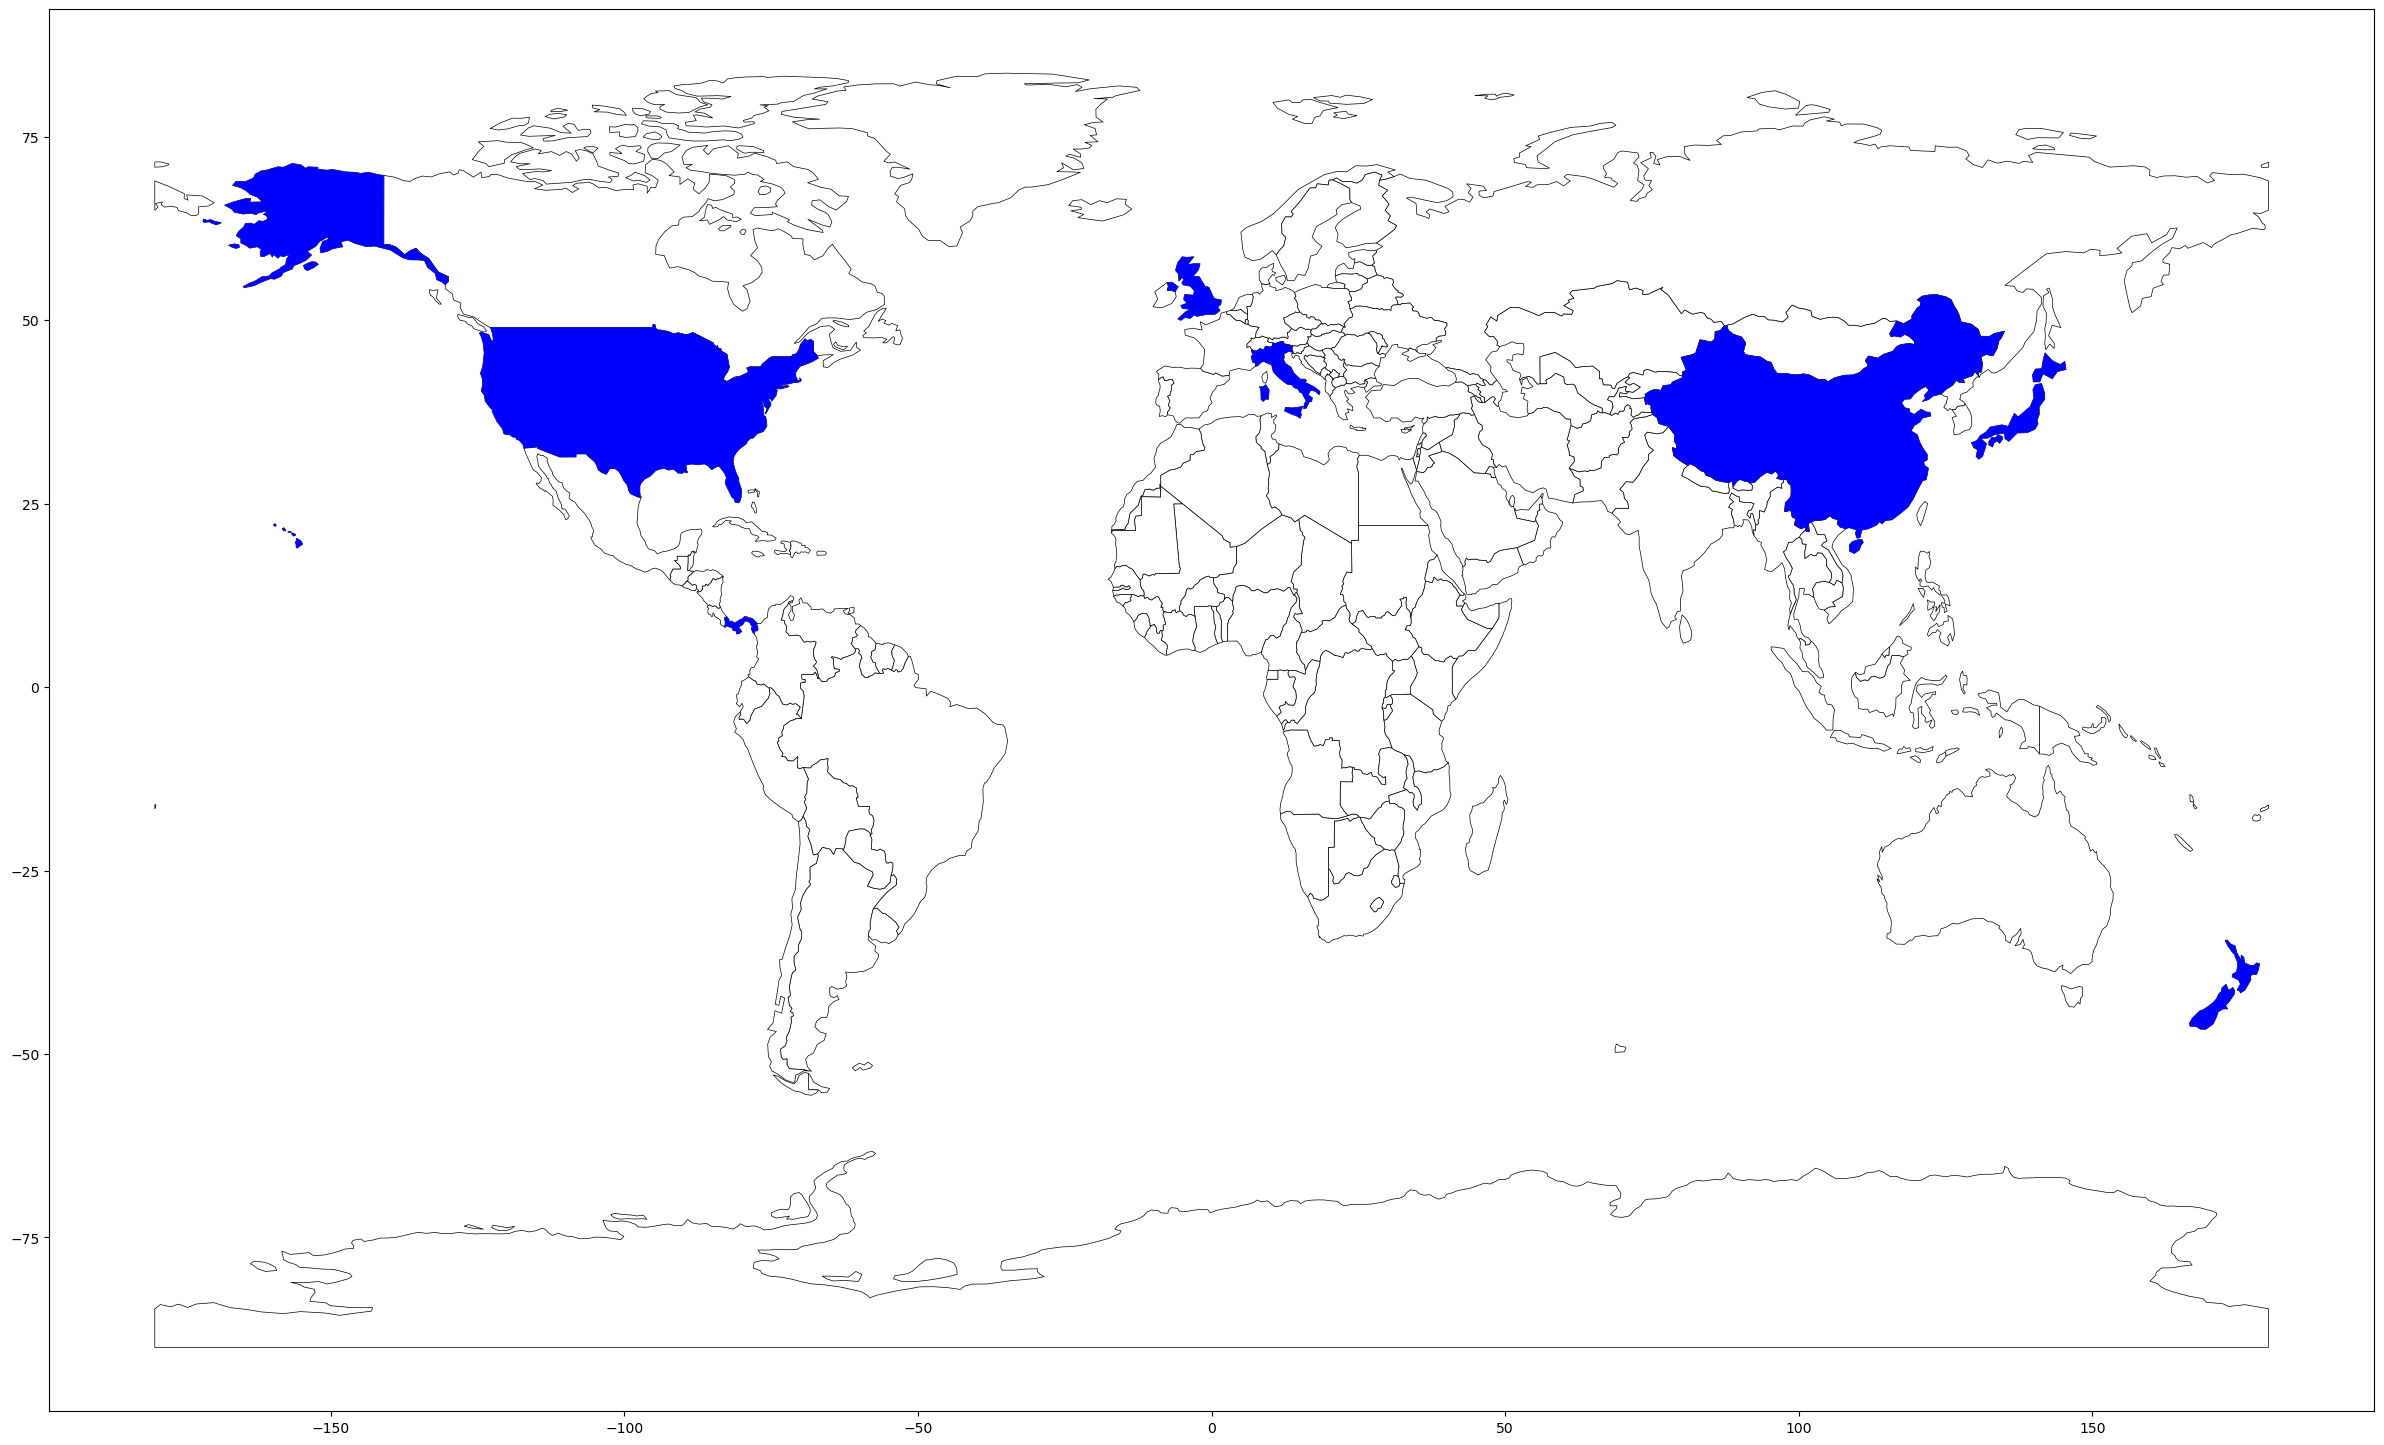

In [70]:
# Create a base world map
world.plot(color='w', figsize=(30, 20), edgecolor='black', aspect="auto", linewidth=0.5)

# Assign ascending indices to the length of the list
indexed_list = list(enumerate(countries))

# Extract the indices
indices = [index for index, word in indexed_list]

# Plot the United States in a different color

colors = plt.cm.Paired(range(len(production_countries)))

for i in range(len(country_data)):
    for_alpha=(0.1*float(indices[i]))+0.2
    country_data[i].plot(color='blue', alpha=1, aspect='1.25', ax=plt.gca())

plt.show()

In [ ]:
# # Create a base world map
# world.plot(color='w', figsize=(30, 20), edgecolor='black', aspect="auto", linewidth=0.5)

# # Assign ascending indices to the length of the list
# indexed_list = list(enumerate(countries))

# # Extract the indices
# indices = [index for index, word in indexed_list]

# # Plot the United States in a different color

# for i in range(len(country_data)):
#     for_alpha=(0.1*float(indices[i]))+0.2
#     country_data[i].plot(color='blue', alpha=for_alpha, aspect='1.25', ax=plt.gca())

# plt.show()

In [ ]:
# Create a bar chart based upon the above data
y_axis=movie_list.groupby('Decades').count()['Title']
y_axis.plot(kind='bar', alpha=0.6, color='blue', title="Number of Movies per decade", xlabel="Decades", ylabel="Number of Movies")

## Pie Chart

In [ ]:
# Minimum Budget
min_budget = movie_list['infl_adj_budget'].min()
# Average Budget
avg_budget = movie_list['infl_adj_budget'].mean()
# Maximum Budget
max_budget = movie_list['infl_adj_budget'].max()
diff = (max_budget-min_budget)/3
# Define the bins and labels
bins=[min_budget,round(min_budget+diff),round(min_budget+2*diff),round(min_budget+3*diff)]
labels = ['Low Budget', 'Average Budget', 'High Budget']
# Cut the 'Budget' column into categories and create a new column 'Budget_Category'
movie_list['Budget_Category'] = pd.cut(movie_list['infl_adj_budget'], bins=bins, labels=labels)
movie_list.sample(10)

In [ ]:
# Pie plot showing the distribution of Budget category using pyplot
budget_distribution = movie_list['Budget_Category'].value_counts().reset_index()
print(budget_distribution)
#create y label
y = [budget_distribution['count'][0],budget_distribution['count'][1],budget_distribution['count'][2]]
#Show Pie Plot
plt.pie(y,autopct='%1.1f%%',labels=['Low Budget','Average Budget','High Budget'])
plt.show()

In [ ]:
genre_df = movie_list.copy(deep=True)
# genre_df
genre_df[['primary_genre', 'sub_genre_1', 'sub_genre_2', 'sub_genre_3', 'sub_genre_4', 'sub_genre_5']] = genre_df['genres'].str.split(', ', expand=True, n=5)
genre_df

In [ ]:

# colors = plt.cm.Paired(range(len(primary_genre)))
primary_genre = genre_df['primary_genre'].value_counts()
primary_genre_length = len(primary_genre)

# Make blank list for explode values and loop through the primary genre length to append 0 after 0.1 accordingly
explode = []
for i in range(primary_genre_length):
    if i == 0:
        explode.append(0.1)
    else:
        explode.append(0)
print(f"Number of primary genres: {len(primary_genre)}")
primary_genre

In [ ]:
plt.figure(figsize=(12, 12))
categories = genre_df['primary_genre'].unique()
# This code would be to include 'exploding' the biggest value out but has an error when 'explode' list is not equal
# to length of primary genres
plt.pie(primary_genre, autopct= "%1.1f%%", shadow=True, startangle=140, pctdistance=1.2, explode=explode)
# plt.pie(primary_genre, autopct= "%1.1f%%", shadow=True, startangle=140, pctdistance=1.2)
plt.legend(categories, loc='best', bbox_to_anchor=(1, 1))
plt.title('Primary Genres')
plt.show()

## Bar Plot

In [ ]:
#Bar plot Budget Categories by Decades
grouped_df = movie_list.groupby(['Decades', 'Budget_Category'])['Title'].count().reset_index()
pivot_df=grouped_df.set_index(['Decades', 'Budget_Category'])
# Set the figure size
plt.figure(figsize=(10,2))  # Width, Height in inches
# Create a stacked bar plot
pivot_df.plot(kind='bar',width=1,color='orange', stacked=True)
# Add labels and a title
plt.xlabel('Decades')
plt.ylabel('Count')
plt.title('Bar Plot of Budget Categories by Decades')
plt.legend("Budget")
# Show the plot
plt.show()

## Histogram Plotting

In [ ]:
# Plot a histogram of budget
plt.hist(movie_list['infl_adj_budget'],bins=5, edgecolor='k')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.title('Histogram of Budget')

In [ ]:
# 
from scipy.stats import shapiro
DataToTest = movie_list['infl_adj_budget']
stat,p = shapiro(DataToTest)
print(f"stat: {stat},p: {p}")
if(p>0.05):
    print("Accept NULL Hypothesis :Budget data is not normally Distributed")
else:
    print("Reject NULL Hypothesis: Budget data is not normally Distributed")

## Scatter Plots with Linear Regression

In [ ]:
# CARTER NOTE: THIS BLOCK BELOW DID NOT SHOW OUR FIRST SCATTER PLOT WHEN RUN FOR ME
    # Looking over the code, could the error be in the "xvalues = xval" lines?

In [ ]:
# Creating a function for computing linear regression
def lin_regress(xval, yval, x_label, y_label): 
    x_values = xval
    y_values = yval
    
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values, c='blueviolet')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,(10,20),fontsize=15,color="red")
    plt.legend(['Regression Line: y = {:.2f}x + {:.2f}'.format(slope, intercept)])
    print("The r-value is: ",rvalue)
    plt.show()
#     x_values = 0
#     y_values = 0

In [ ]:
# Create a scatter plot for regression analysis

xval = movie_list['Year']
yval = movie_list['runtime'].astype(int)
x_label='Years'
y_label='Runtime(mins) of Movies'

lin_regress(xval, yval, x_label, y_label)

In [ ]:
# Create a scatter plot for regression analysis: Budget vs. tmdb

xval = movie_list['budget'].astype(int)
yval = movie_list['tmdb_rating'].astype(float)
x_label='Budget'
y_label='tmdb rating'

lin_regress(xval, yval, x_label, y_label)

In [ ]:
# Create a scatter plot for regression analysis: Budget vs. imbd Rating

xval = movie_list['budget'].astype(int)
yval = movie_list['imdb_rating'].astype(float)
x_label='Budget'
y_label='IMDb rating'

lin_regress(xval, yval, x_label, y_label)

In [ ]:
# Create a scatter plot for regression analysis: Revenue vs. imbd Rating

xval = movie_list['revenue'].astype(float)
yval = movie_list['imdb_rating'].astype(float)
x_label='Revenue'
y_label='imdb rating'

lin_regress(xval, yval, x_label, y_label)

In [ ]:
# Create a scatter plot for regression analysis: Revenue vs. Runtime

xval = movie_list['revenue'].astype(float)
yval = movie_list['runtime'].astype(int)
x_label='Revenue'
y_label='Runtime(mins)'

lin_regress(xval, yval, x_label, y_label)

# Data Testing

## 

In [ ]:
#TEST NULL HYPOTHESIS(budget and revenue)
#H0: There is a significant association between budget and revenue of a movie.
#H1: There is no significant association between budget and revenue of a movie
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(movie_list['infl_adj_budget'], movie_list['infl_adj_revenue'])

# Perform the chi-square test for independence
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)

alpha = 0.05  # Significance level

if p < alpha:
    print("Accept Null Hypothesis: There is a significant association between budget and revenue of a movie.")
else:
    print("Reject Null Hypothesis:There is no significant association between budget and revenue.")

In [ ]:
#Identifying Outliers in Movie Runtimes Over the Years
import seaborn as sns
ax = sns.boxplot(x='Decades',y='runtime',data=movie_list)

# Incorporating Oscar and Golden Globe Data

### Oscar dataset import and cleaning

In [ ]:
# Import the Oscar csv to analyze
oscar_list = pd.read_csv("the_oscar_award.csv")
print(oscar_list.shape)
oscar_list.head(2)

In [ ]:
# Check for NaN values in the film column of the Oscar List
oscar_list["film"].isnull().value_counts()

In [ ]:
# Drop the NaN values and the "False" winners to clean the data
oscar_list.dropna(how="any", inplace=True)
oscar_winners = oscar_list["winner"]==True

oscars = oscar_list[oscar_winners]
print(oscars.shape)
oscars

In [ ]:
# Count the number of wins each film has and turn that series into a DataFrame
oscar_wins = oscars[["film", "year_film"]].value_counts()
oscar_win_df = oscar_wins.reset_index()
oscar_win_df

In [ ]:
# Rename the columns of the DataFrame to cleanly merge with the movie data
oscar_win_df = oscar_win_df.rename(columns={'film': 'Title', 'year_film': 'Year', 'count': 'Oscar_Wins'})
oscar_win_df

### Golden Globe dataset import and cleaning

In [ ]:
# Import the golden globes csv to analyze
gglobe_list = pd.read_csv("golden_globe_awards.csv")
print(gglobe_list.shape)
gglobe_list.head()

# gglobe_list

In [ ]:
# Check for NaN values in the film column of the Golden Globe List
gglobe_list["film"].isnull().value_counts()

In [ ]:
# Drop the NaN values and the "False" winners to clean the data
# gglobe_list.dropna(how="any", inplace=True)
gglobe_winners = gglobe_list["win"]==True
# gglobe_winners
gglobes = gglobe_list[gglobe_winners]

# Update the 'film' column where it is NaN with values from the 'nominee' column
gglobes['film'] = gglobes['film'].fillna(gglobes['nominee'])
gglobes.sample(10)

# print(gglobes.shape)
# gglobes

In [ ]:
# # Drop the NaN values and the "False" winners to clean the data
# gglobe_list.dropna(how="any", inplace=True)
# gglobe_winners = gglobe_list["win"]==True
# gglobe_winners

# gglobes = gglobe_list[gglobe_winners]
# print(gglobes.shape)
# gglobes

In [ ]:
# Count the number of wins each film has and turn that series into a DataFrame
gglobe_count = gglobes[["film", "year_film"]].value_counts()
gglobe_win_df = gglobe_count.reset_index()
gglobe_win_df

In [ ]:
# Rename the columns of the DataFrame to cleanly merge with the movie data
gglobe_win_df = gglobe_win_df.rename(columns={'film': 'Title', 'year_film': 'Year', 'count': 'Golden_Globe_Wins'})
gglobe_win_df

## Merging the Oscars and Golden Globes DataFrames into the Movie List DataFrame

In [ ]:
# Referencing the movie_list for ease of coding
print(movie_list.shape)
movie_list.head(1)

In [ ]:
# Individually merge the Oscars and Golden Globes DataFrames into the master movie list
oscar_awards = pd.merge(movie_list, oscar_win_df, how="inner", on=["Title", "Year"])
print(oscar_awards.shape)
oscar_awards.head()

In [ ]:
gglobe_awards = pd.merge(movie_list, gglobe_win_df, how="inner", on=["Title", "Year"])
print(gglobe_awards.shape)
gglobe_awards.head()

In [ ]:
# Make a DataFrame merging Golden Globe Awards data onto the merged Oscar data to show only films with wins in both
both_awards = pd.merge(oscar_awards, gglobe_win_df, how="inner", on=["Title", "Year"])
print(both_awards.shape)
both_awards

In [ ]:
# Sum the Oscar and Golden Globe Award wins into a new column called cumulative awards
both_awards['Cumulative_Awards'] = ''
for index,row in both_awards.iterrows():
    both_awards.loc[index, "Cumulative_Awards"] = both_awards.loc[index,'Oscar_Wins']+both_awards.loc[index,'Golden_Globe_Wins']

both_awards.sort_values(by='Cumulative_Awards',ascending = False,inplace=True)
both_awards.head(50)

In [ ]:
# Sort the data descending and grab the top 20 cumulative winners to do visualizations with
top20_both_awards = both_awards.sort_values(by='Cumulative_Awards', ascending=False)
top20_movies = top20_both_awards.iloc[0:20, :] 
top20_movies.head()

In [ ]:
# plt.barh(x, y)
x=top20_movies['Title']
y=top20_movies['Cumulative_Awards']
plt.figure(figsize=(10,5))
plt.title('Top 20 movies with total Oscar & Golden Globe wins')
plt.barh(x,y,color='green',alpha=0.7)

In [ ]:
# Take a look at how many awards were won by each decade
per_decade_wins=both_awards['Decades'].value_counts()
per_decade_wins

In [ ]:
# Bar plot for cumulative Oscar and Golden Globe wins by Decade
decade_groupby = both_awards.groupby('Decades')
decades_sum=decade_groupby['Cumulative_Awards'].sum().reset_index()
decades_sum['Cumulative_Awards']
x=decades_sum['Decades']
y=decades_sum['Cumulative_Awards']
#plt.xlabel("Total oscar and golden globe wins")

plt.figure(figsize=(8,5))
plt.title(f"Each Decades' # of Movies with Oscar and Golden Globe Wins")
plt.barh(x,y,color='red',alpha=0.5)

### Pulling genre and produciton country information out of the DataFrame

In [ ]:
# # Testing the Pandas "explode" function
# checkexplode = movie_list["genres"].explode('drama')
# checkexplode